Train 데이터: 185,072
Validation 데이터: 89,105
Test 데이터: 140,474

--- 모델 학습 시작 ---
[0]	validation_0-rmse:0.28823	validation_1-rmse:0.28742
[97]	validation_0-rmse:0.28611	validation_1-rmse:0.28729

최적 반복 횟수: 47

=== 최종 모델 성능 ===
Test Spearman IC (rank correlation): 0.0278
(0.05 이상이면 의미 있는 퀀트 신호로 간주됨)


c:\Users\rkdtk\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rkdtk\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rkdtk\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49692 (\N{HANGUL SYLLABLE SUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rkdtk\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rkdtk\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_i

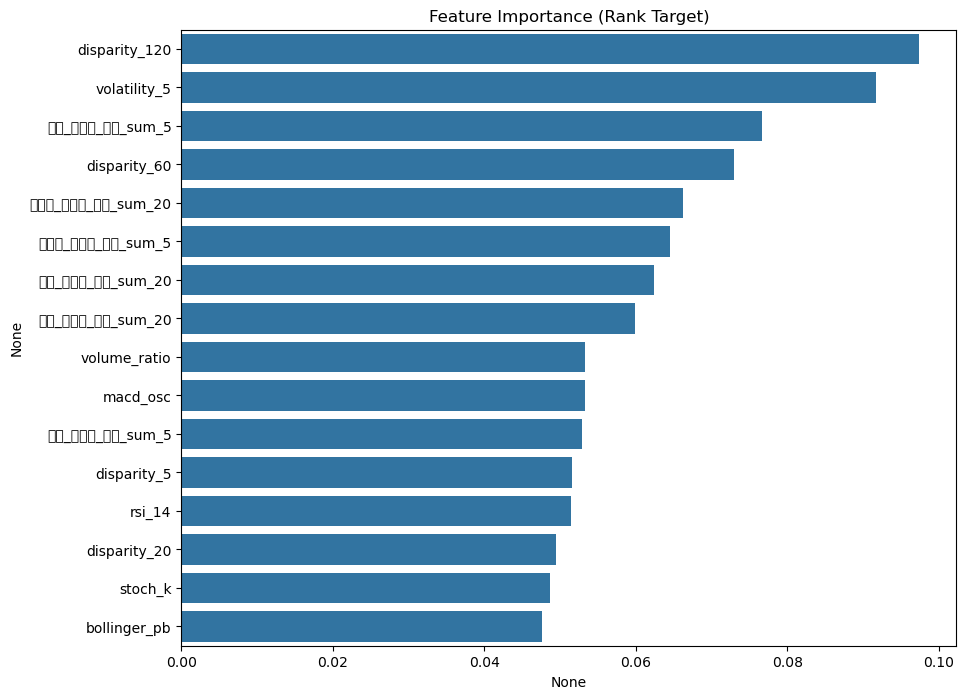

전략 기간: 2022-01-03T00:00:00.000000000 ~ 2024-12-02T00:00:00.000000000
총 리밸런싱 횟수: 36회

=== [Rank Model] 월간 백테스트 결과 (Cost 0.2%) ===
AI Top 10 누적 수익률: -16.99%
시장(BM) 누적 수익률 : 8.49%
AI Bottom 10 수익률  : 41.94%


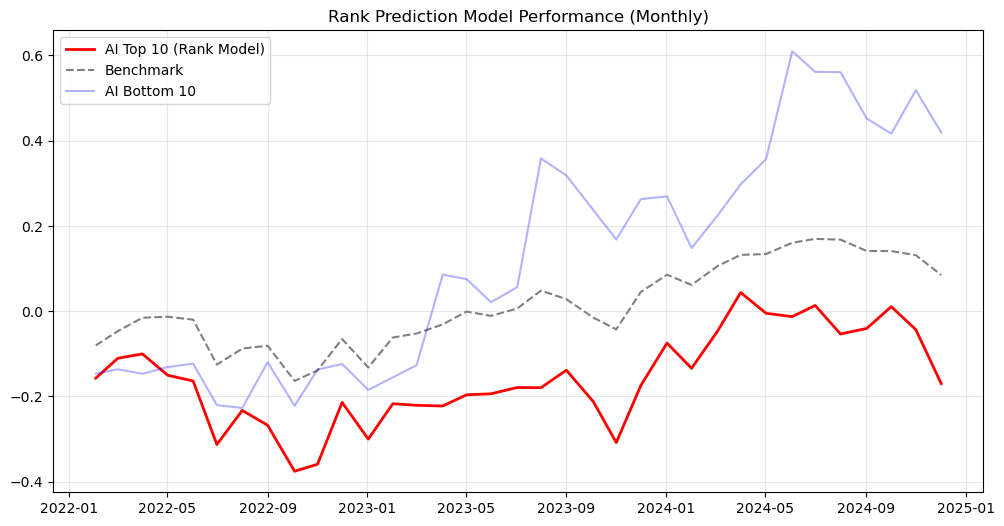

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

df1 = pd.read_csv('../단기모멘텀.csv', dtype={'ticker':str})
df2 = pd.read_csv('../24.12_수급,거래 데이터.csv', dtype={'ticker':str})

# 1. 날짜 컬럼을 datetime 형식으로 통일 (오류 방지)
df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])

# df1(가격 정보)을 기준으로 df2(수급 정보)를 병합
merged_df = pd.merge(df1, df2, on=['date', 'ticker'], how='left')


# 1. 데이터 준비 (기존 merged_df 복사)
# date, ticker, 시가, 고가, 저가, 종가, 거래량, 기관/외국인 수급 컬럼이 있다고 가정
df = merged_df.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['ticker', 'date'])

# -----------------------------------------------------------
# [섹션 A] 추세 및 모멘텀 지표 (Trend & Momentum)
# : 주가가 오르는 힘과 방향을 측정
# -----------------------------------------------------------

# 1. 이동평균 이격도 (Disparity)
# 현재 주가가 5일/20일/60일/120일 평균 대비 얼마나 높은가? (1.0 이상이면 평균 위)
for w in [5, 20, 60, 120]:
    ma = df.groupby('ticker')['종가'].rolling(window=w).mean().reset_index(0, drop=True)
    df[f'disparity_{w}'] = df['종가'] / ma

# 2. RSI (상대강도지수, 14일)
# 0~100 사이 값. 70 이상 과매수, 30 이하 과매도
def calc_rsi(x, window=14):
    delta = x.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / (loss + 1e-9) # 0 나누기 방지
    return 100 - (100 / (1 + rs))

df['rsi_14'] = df.groupby('ticker')['종가'].transform(lambda x: calc_rsi(x))

# 3. MACD & Signal (추세 전환 포착)
# MACD 선이 Signal 선을 돌파할 때가 매수/매도 타이밍
def calc_macd_oscillator(x):
    exp12 = x.ewm(span=12, adjust=False).mean()
    exp26 = x.ewm(span=26, adjust=False).mean()
    macd = exp12 - exp26
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd - signal # 오실레이터 (히스토그램)

df['macd_osc'] = df.groupby('ticker')['종가'].transform(lambda x: calc_macd_oscillator(x))

# 4. 스토캐스틱 (Stochastic Fast %K) - 단기 파동 확인
def calc_stochastic_k(df_grp, window=14):
    low_min = df_grp['저가'].rolling(window=window).min()
    high_max = df_grp['고가'].rolling(window=window).max()
    k = ((df_grp['종가'] - low_min) / (high_max - low_min + 1e-9)) * 100
    return k

# groupby().apply() 대신 transform 사용을 위해 함수 구조 조정 필요하나,
# 성능상 반복문 없이 처리하기 위해 아래 방식 사용
df['low_14'] = df.groupby('ticker')['저가'].rolling(window=14).min().reset_index(0, drop=True)
df['high_14'] = df.groupby('ticker')['고가'].rolling(window=14).max().reset_index(0, drop=True)
df['stoch_k'] = ((df['종가'] - df['low_14']) / (df['high_14'] - df['low_14'] + 1e-9)) * 100

# -----------------------------------------------------------
# [섹션 B] 변동성 지표 (Volatility)
# : 주가가 얼마나 요동치는지(리스크) 측정
# -----------------------------------------------------------

# 5. 볼린저 밴드 (Bollinger Bands) 위치값 (%b)
# 주가가 밴드 상단(1.0)에 있는지 하단(0.0)에 있는지 확인
def calc_bollinger_pb(x, window=20):
    ma = x.rolling(window=window).mean()
    std = x.rolling(window=window).std()
    upper = ma + (std * 2)
    lower = ma - (std * 2)
    pb = (x - lower) / (upper - lower + 1e-9)
    return pb

df['bollinger_pb'] = df.groupby('ticker')['종가'].transform(lambda x: calc_bollinger_pb(x))

# 6. 일일 변동성 (최근 5일간 등락폭의 표준편차)
df['volatility_5'] = df.groupby('ticker')['등락률'].rolling(window=5).std().reset_index(0, drop=True)

# -----------------------------------------------------------
# [섹션 C] 수급 지표 (Supply & Demand) - 매우 중요
# : 외국인/기관이 실제로 사고 있는지 확인
# -----------------------------------------------------------

# 7. 수급 주체별 누적 순매수 (Accumulated Net Buying)
# 단기(5일), 중기(20일), 장기(60일) 동안 얼마나 모았나?
investor_cols = ['외국인_순매수_금액', '기관_순매수_금액', '개인_순매수_금액']

for col in investor_cols:
    # 절대 금액은 종목별 시총 차이가 크므로, 로그 변환하거나 스케일링이 필요하지만
    # 여기서는 '방향성'을 보기 위해 20일 이동평균 대비 현재 수급 강도로 변환
    # (단순 누적은 주가가 계속 오르면 값도 계속 커지는 문제가 있음)
    
    # 전략: 최근 5일/20일 누적 순매수 금액
    df[f'{col}_sum_5'] = df.groupby('ticker')[col].rolling(window=5).sum().reset_index(0, drop=True)
    df[f'{col}_sum_20'] = df.groupby('ticker')[col].rolling(window=20).sum().reset_index(0, drop=True)

# 8. 거래량 회전율 (Volume Ratio)
# 최근 5일 평균 거래량이 60일 평균 대비 얼마나 터졌나? (거래량 급증 포착)
vol_5 = df.groupby('ticker')['거래량'].rolling(window=5).mean().reset_index(0, drop=True)
vol_60 = df.groupby('ticker')['거래량'].rolling(window=60).mean().reset_index(0, drop=True)
df['volume_ratio'] = vol_5 / (vol_60 + 1e-9)

# -----------------------------------------------------------
# [섹션 D] 타겟 생성 (Target) & 정리
# -----------------------------------------------------------

# 9. 타겟: 향후 10일 수익률 (Shift -10)
df['target_10d'] = df.groupby('ticker')['종가'].shift(-10) / df['종가'] - 1

# 10. 백테스트용 내일 수익률 (Shift -1)
# 모델이 오늘 예측하면, 실제 수익은 내일 종가 기준 등으로 발생
df['next_day_ret'] = df.groupby('ticker')['종가'].pct_change().shift(-1)

# 불필요한 중간 계산 컬럼 제거 (선택)
drop_cols = ['low_14', 'high_14'] 
df = df.drop(columns=drop_cols)

# 모델에 넣을 최종 Feature 리스트 정의
features = [
    # 추세
    'disparity_5', 'disparity_20', 'disparity_60', 'disparity_120',
    'rsi_14', 'macd_osc', 'stoch_k',
    # 변동성
    'bollinger_pb', 'volatility_5',
    # 수급 (금액 데이터가 있는 경우)
    '외국인_순매수_금액_sum_5', '외국인_순매수_금액_sum_20',
    '기관_순매수_금액_sum_5', '기관_순매수_금액_sum_20',
    '개인_순매수_금액_sum_5', '개인_순매수_금액_sum_20',
    # 거래량
    'volume_ratio'
]

df_clean = df.dropna(subset=features + ['target_10d'])


# -----------------------------------------------------------
# 1. y값 생성 (10일 수익률 → 날짜별 순위로 변환)
# -----------------------------------------------------------
# 날짜별로 10일 수익률의 "순위(rank)" 를 생성 (0~1 사이)
# pct=True → 상대순위(percentile rank)
df['target_rank'] = df.groupby('date')['target_10d'].rank(pct=True)

# 결측치 제거
features = [
    'disparity_5', 'disparity_20', 'disparity_60', 'disparity_120',
    'rsi_14', 'macd_osc', 'stoch_k', 'bollinger_pb', 'volatility_5',
    '외국인_순매수_금액_sum_5', '외국인_순매수_금액_sum_20',
    '기관_순매수_금액_sum_5', '기관_순매수_금액_sum_20',
    '개인_순매수_금액_sum_5', '개인_순매수_금액_sum_20',
    'volume_ratio'
]

model_df = df.dropna(subset=features + ['target_rank'])

# -----------------------------------------------------------
# 2. Train / Validation / Test split
# -----------------------------------------------------------
train = model_df[model_df['date'].between('2015-01-01', '2019-12-31')]
val   = model_df[model_df['date'].between('2020-01-01', '2021-12-31')]
test  = model_df[model_df['date'].between('2022-01-01', '2024-12-31')]

print(f"Train 데이터: {len(train):,}")
print(f"Validation 데이터: {len(val):,}")
print(f"Test 데이터: {len(test):,}")

# X, y 정의 (y = rank)
X_train, y_train = train[features], train['target_rank']
X_val,   y_val   = val[features],   val['target_rank']
X_test,  y_test  = test[features],  test['target_rank']

# -----------------------------------------------------------
# 3. XGBoost 모델 학습 (Early Stopping 포함)
# -----------------------------------------------------------
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

print("\n--- 모델 학습 시작 ---")
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100
)

print(f"\n최적 반복 횟수: {model.best_iteration}")

# -----------------------------------------------------------
# 4. Test 예측 + 성능 평가 (IC)
# -----------------------------------------------------------
y_pred = model.predict(X_test)

# 순위 기반 IC (Spearman rank correlation)
test_result = pd.DataFrame({'actual_rank': y_test, 'pred_rank': y_pred})
ic = test_result.corr(method='spearman').iloc[0, 1]

print("\n=== 최종 모델 성능 ===")
print(f"Test Spearman IC (rank correlation): {ic:.4f}")
print("(0.05 이상이면 의미 있는 퀀트 신호로 간주됨)")

# -----------------------------------------------------------
# 5. Feature Importance 시각화
# -----------------------------------------------------------
plt.figure(figsize=(10, 8))
imp = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
sns.barplot(x=imp, y=imp.index)
plt.title('Feature Importance (Rank Target)')
plt.show()


# -----------------------------------------------------------
# 1. 월별 리밸런싱 날짜 추출 (Test 기간)
# -----------------------------------------------------------
# Test 데이터 복사
backtest_df = test.copy()

# [중요] Rank 학습된 모델로 예측 (결과는 0~1 사이의 순위 점수)
backtest_df['pred_rank'] = model.predict(backtest_df[features])

# 월초 날짜 추출
monthly_dates = backtest_df.groupby([backtest_df['date'].dt.year, backtest_df['date'].dt.month])['date'].min().values
monthly_dates = sorted(monthly_dates)

print(f"전략 기간: {monthly_dates[0]} ~ {monthly_dates[-1]}")
print(f"총 리밸런싱 횟수: {len(monthly_dates)}회")

# -----------------------------------------------------------
# 2. 월간 수익률 시뮬레이션 (수수료 0.2% 적용)
# -----------------------------------------------------------
monthly_log = []
cost = 0.002  # 0.2% (세금/수수료)

for i in range(len(monthly_dates) - 1):
    buy_date = monthly_dates[i]       # 매수일
    sell_date = monthly_dates[i+1]    # 매도일
    
    # 매수일 데이터
    buy_data = backtest_df[backtest_df['date'] == buy_date]
    if len(buy_data) < 20: continue
        
    # [전략] 예측 순위(pred_rank)가 높은 상위 10개 종목 선정
    top_10_tickers = buy_data.sort_values(by='pred_rank', ascending=False).head(10)['ticker'].tolist()
    
    # [비교] 하위 10개 (Short 관점)
    bottom_10_tickers = buy_data.sort_values(by='pred_rank', ascending=True).head(10)['ticker'].tolist()
    
    # 수익률 계산 함수
    def get_period_return(tickers, b_date, s_date):
        b_prices = backtest_df[(backtest_df['date'] == b_date) & (backtest_df['ticker'].isin(tickers))].set_index('ticker')['종가']
        s_prices = backtest_df[(backtest_df['date'] == s_date) & (backtest_df['ticker'].isin(tickers))].set_index('ticker')['종가']
        valid = b_prices.index.intersection(s_prices.index)
        if len(valid) == 0: return 0.0
        return ((s_prices[valid] / b_prices[valid]) - 1).mean()

    # 전략 수익률 (수수료 차감)
    strategy_ret = get_period_return(top_10_tickers, buy_date, sell_date) - cost
    
    # 하위 수익률 (수수료 차감)
    bottom_ret = get_period_return(bottom_10_tickers, buy_date, sell_date) - cost
    
    # 벤치마크 수익률 (KOSPI 200 전체)
    all_tickers = buy_data['ticker'].tolist()
    bm_ret = get_period_return(all_tickers, buy_date, sell_date)

    monthly_log.append({
        'date': sell_date,
        'Strategy_Top10': strategy_ret,
        'Strategy_Bottom10': bottom_ret,
        'Benchmark': bm_ret
    })

# 결과 정리
res = pd.DataFrame(monthly_log).set_index('date')

# -----------------------------------------------------------
# 3. 성과 지표 및 시각화
# -----------------------------------------------------------
cum_ret = (1 + res).cumprod() - 1
final_ret = cum_ret.iloc[-1]

print(f"\n=== [Rank Model] 월간 백테스트 결과 (Cost 0.2%) ===")
print(f"AI Top 10 누적 수익률: {final_ret['Strategy_Top10']*100:.2f}%")
print(f"시장(BM) 누적 수익률 : {final_ret['Benchmark']*100:.2f}%")
print(f"AI Bottom 10 수익률  : {final_ret['Strategy_Bottom10']*100:.2f}%")

# 그래프
plt.figure(figsize=(12, 6))
plt.plot(cum_ret.index, cum_ret['Strategy_Top10'], label='AI Top 10 (Rank Model)', color='red', linewidth=2)
plt.plot(cum_ret.index, cum_ret['Benchmark'], label='Benchmark', color='gray', linestyle='--')
plt.plot(cum_ret.index, cum_ret['Strategy_Bottom10'], label='AI Bottom 10', color='blue', alpha=0.3)
plt.title('Rank Prediction Model Performance (Monthly)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

지표 생성 중... 완료!

데이터셋 크기 - Train: 204,203, Val: 90,981, Test: 142,061
모델 학습 시작 (Early Stopping 적용)...
학습 완료! (Best Iteration: 87)

✅ 모델 예측 정확도 (IC): 0.0303
   (참고: 0.03 이상이면 유의미, 0.05 이상이면 매우 우수)

백테스트 시뮬레이션 중 (Monthly Rebalancing)...

 최종 성과 보고서 (2022.01 ~ 2024.12)
 * 리밸런싱: 월 1회 (매월 초)
 * 거래비용: 0.2% 적용 완료
지표              | AI Top 10    | KOSPI 200   
--------------------------------------------------
누적 수익률          |       -27.0% |         7.0%
연환산(CAGR)       |       -10.2% |         2.3%
MDD (최대낙폭)      |       -30.8% |       -15.2%
Sharpe Ratio    |       -0.30  |        0.22
--------------------------------------------------


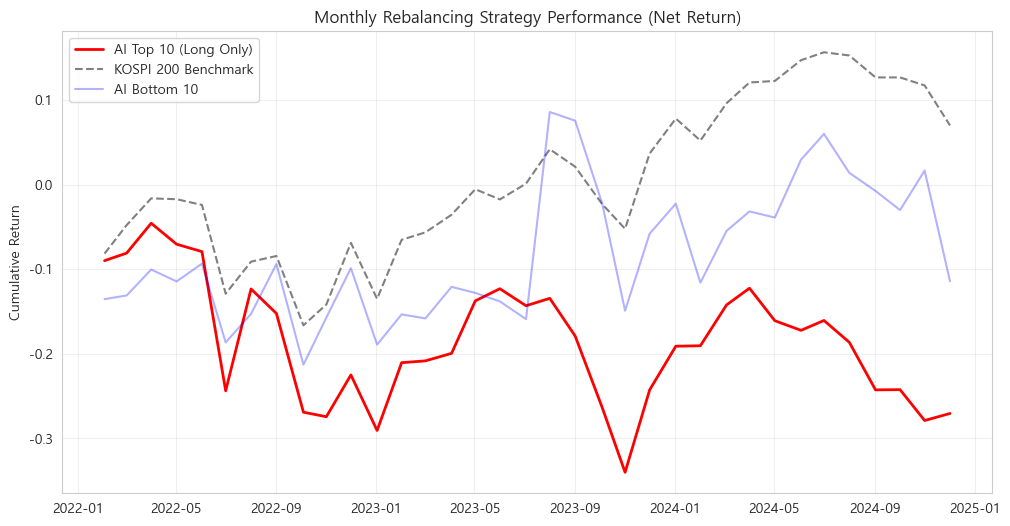

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (Colab 등 환경에 맞춰 설정 필요, 깨짐 방지용)
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# ==============================================================================
# 1. 데이터 병합 및 전처리
# ==============================================================================
# 가상의 df1(가격), df2(수급)가 있다고 가정하고 병합합니다.
# 실제 사용 시 df1, df2는 로드된 상태여야 합니다.

df1 = pd.read_csv('../단기모멘텀.csv', dtype={'ticker':str})
df2 = pd.read_csv('../24.12_수급,거래 데이터.csv', dtype={'ticker':str})

df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])
df1['ticker'] = df1['ticker'].astype(str)
df2['ticker'] = df2['ticker'].astype(str)

# df1(가격) 기준으로 df2(수급) 병합 (Left Join)
df = pd.merge(df1, df2, on=['date', 'ticker'], how='left')

# 수급 데이터 결측치는 0으로 채움 (데이터 없음 = 순매수 0)
investor_cols = ['기관_순매수_수량', '개인_순매수_수량', '외국인_순매수_수량',
                 '기관_순매수_금액', '개인_순매수_금액', '외국인_순매수_금액']
df[investor_cols] = df[investor_cols].fillna(0)

# 날짜/종목순 정렬
df = df.sort_values(['ticker', 'date'])

# ==============================================================================
# 2. Feature Engineering (최대 20일 제한 -> 데이터 손실 최소화)
# ==============================================================================
print("지표 생성 중...", end="")

# (1) 추세: 이격도 (5일, 20일)
for w in [5, 20]:
    ma = df.groupby('ticker')['종가'].rolling(window=w).mean().reset_index(0, drop=True)
    df[f'disparity_{w}'] = df['종가'] / ma

# (2) 모멘텀: RSI (14일)
def calc_rsi(x, window=14):
    delta = x.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / (loss + 1e-9)
    return 100 - (100 / (1 + rs))
df['rsi_14'] = df.groupby('ticker')['종가'].transform(lambda x: calc_rsi(x))

# (3) 추세: MACD (12, 26, 9)
def calc_macd(x):
    exp12 = x.ewm(span=12, adjust=False).mean()
    exp26 = x.ewm(span=26, adjust=False).mean()
    macd = exp12 - exp26
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd - signal
df['macd_osc'] = df.groupby('ticker')['종가'].transform(lambda x: calc_macd(x))

# (4) 변동성: 볼린저 밴드 %B (20일)
def calc_bb(x, window=20):
    ma = x.rolling(window=window).mean()
    std = x.rolling(window=window).std()
    upper = ma + (std * 2)
    lower = ma - (std * 2)
    return (x - lower) / (upper - lower + 1e-9)
df['bollinger_pb'] = df.groupby('ticker')['종가'].transform(lambda x: calc_bb(x))

# (5) 변동성: 5일 등락률 표준편차
df['volatility_5'] = df.groupby('ticker')['등락률'].rolling(window=5).std().reset_index(0, drop=True)

# (6) 수급: 주체별 누적 순매수 (5일, 20일)
# 금액 데이터가 있으면 금액 우선, 없으면 수량 사용
target_inv_col = '순매수_금액' if '외국인_순매수_금액' in df.columns else '순매수_수량'
for subject in ['외국인', '기관', '개인']:
    col_name = f'{subject}_{target_inv_col}'
    if col_name in df.columns:
        df[f'{col_name}_sum_5'] = df.groupby('ticker')[col_name].rolling(window=5).sum().reset_index(0, drop=True)
        df[f'{col_name}_sum_20'] = df.groupby('ticker')[col_name].rolling(window=20).sum().reset_index(0, drop=True)

# (7) 거래량: 회전율 (5일 vs 20일)
v_5 = df.groupby('ticker')['거래량'].rolling(window=5).mean().reset_index(0, drop=True)
v_20 = df.groupby('ticker')['거래량'].rolling(window=20).mean().reset_index(0, drop=True)
df['volume_ratio'] = v_5 / (v_20 + 1e-9)

print(" 완료!")

# ==============================================================================
# 3. Target 생성 (Rank Prediction)
# ==============================================================================
# (1) 10일 후 수익률 계산
df['target_10d'] = df.groupby('ticker')['종가'].shift(-10) / df['종가'] - 1

# (2) 날짜별 수익률 순위 산출 (0.0 ~ 1.0, 1.0이 1등)
df['target_rank'] = df.groupby('date')['target_10d'].rank(pct=True)

# (3) 사용할 Feature 목록 정의 (Max 20일)
features = [
    'disparity_5', 'disparity_20',
    'rsi_14', 'macd_osc', 'bollinger_pb', 'volatility_5', 'volume_ratio'
]
# 수급 컬럼 자동 추가
features += [c for c in df.columns if 'sum_5' in c or 'sum_20' in c]

# 결측치 제거
model_df = df.dropna(subset=features + ['target_rank']).copy()

# ==============================================================================
# 4. 데이터 분할 (Train / Val / Test)
# ==============================================================================
train = model_df[model_df['date'].between('2015-01-01', '2019-12-31')]
val   = model_df[model_df['date'].between('2020-01-01', '2021-12-31')]
test  = model_df[model_df['date'].between('2022-01-01', '2024-12-31')]

print(f"\n데이터셋 크기 - Train: {len(train):,}, Val: {len(val):,}, Test: {len(test):,}")

# ==============================================================================
# 5. XGBoost 모델링 (Ranking 학습)
# ==============================================================================
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

print("모델 학습 시작 (Early Stopping 적용)...")
model.fit(
    train[features], train['target_rank'],
    eval_set=[(train[features], train['target_rank']), (val[features], val['target_rank'])],
    verbose=0 # 로그 출력 생략
)
print(f"학습 완료! (Best Iteration: {model.best_iteration})")

# ==============================================================================
# 6. 정확도 검증 (IC: Information Coefficient)
# ==============================================================================
test_copy = test.copy()
test_copy['pred_rank'] = model.predict(test_copy[features])

# 예측 순위와 실제 순위의 상관관계 측정
ic = test_copy[['target_rank', 'pred_rank']].corr(method='spearman').iloc[0, 1]
print(f"\n✅ 모델 예측 정확도 (IC): {ic:.4f}")
print("   (참고: 0.03 이상이면 유의미, 0.05 이상이면 매우 우수)")

# ==============================================================================
# 7. 월간 리밸런싱 백테스트 (수수료 0.2% 적용)
# ==============================================================================
print("\n백테스트 시뮬레이션 중 (Monthly Rebalancing)...")

# 월초 날짜 추출
monthly_dates = sorted(test_copy.groupby([test_copy['date'].dt.year, test_copy['date'].dt.month])['date'].min().values)
monthly_log = []
cost = 0.002 # 수수료 0.2%

for i in range(len(monthly_dates) - 1):
    buy_date = monthly_dates[i]
    sell_date = monthly_dates[i+1]

    # 매수일 데이터 추출
    day_data = test_copy[test_copy['date'] == buy_date]
    if len(day_data) < 20: continue

    # [Top 10] 예측 점수가 높은 상위 10개 (Long)
    top_10 = day_data.sort_values(by='pred_rank', ascending=False).head(10)['ticker'].tolist()
    
    # [Bottom 10] 예측 점수가 낮은 하위 10개 (Short 관점)
    bottom_10 = day_data.sort_values(by='pred_rank', ascending=True).head(10)['ticker'].tolist()

    # 구간 수익률 계산 함수
    def calc_return(tickers, d1, d2):
        p1 = test_copy[(test_copy['date'] == d1) & (test_copy['ticker'].isin(tickers))].set_index('ticker')['종가']
        p2 = test_copy[(test_copy['date'] == d2) & (test_copy['ticker'].isin(tickers))].set_index('ticker')['종가']
        valid = p1.index.intersection(p2.index)
        if len(valid) == 0: return 0.0
        return ((p2[valid] / p1[valid]) - 1).mean()

    # 수익률 계산 (Top 10은 수수료 차감)
    r_top = calc_return(top_10, buy_date, sell_date) - cost
    r_bottom = calc_return(bottom_10, buy_date, sell_date) - cost # 비교를 위해 얘도 차감
    r_bm = calc_return(day_data['ticker'].unique(), buy_date, sell_date) # 벤치마크 (KOSPI200)

    monthly_log.append({'date': sell_date, 'Strategy': r_top, 'Benchmark': r_bm, 'Bottom10': r_bottom})

res = pd.DataFrame(monthly_log).set_index('date')
cum_ret = (1 + res).cumprod() - 1

# ==============================================================================
# 8. 성과 지표 산출 (CAGR, MDD, Sharpe)
# ==============================================================================
def calculate_metrics(series):
    # 누적 수익률
    total_ret = (1 + series).cumprod().iloc[-1] - 1
    # CAGR (월간 데이터이므로 12 곱함)
    cagr = (1 + total_ret) ** (12 / len(series)) - 1
    # MDD
    wealth = (1 + series).cumprod()
    peak = wealth.cummax()
    mdd = ((wealth - peak) / peak).min()
    # Sharpe (무위험이자율 0 가정)
    sharpe = (series.mean() / series.std()) * np.sqrt(12)
    return total_ret, cagr, mdd, sharpe

strat_metrics = calculate_metrics(res['Strategy'])
bm_metrics = calculate_metrics(res['Benchmark'])

print("\n" + "="*50)
print(f" 최종 성과 보고서 (2022.01 ~ 2024.12)")
print(f" * 리밸런싱: 월 1회 (매월 초)")
print(f" * 거래비용: 0.2% 적용 완료")
print("="*50)
print(f"{'지표':<15} | {'AI Top 10':<12} | {'KOSPI 200':<12}")
print("-" * 50)
print(f"{'누적 수익률':<15} | {strat_metrics[0]*100:>11.1f}% | {bm_metrics[0]*100:>11.1f}%")
print(f"{'연환산(CAGR)':<15} | {strat_metrics[1]*100:>11.1f}% | {bm_metrics[1]*100:>11.1f}%")
print(f"{'MDD (최대낙폭)':<15} | {strat_metrics[2]*100:>11.1f}% | {bm_metrics[2]*100:>11.1f}%")
print(f"{'Sharpe Ratio':<15} | {strat_metrics[3]:>11.2f}  | {bm_metrics[3]:>11.2f}")
print("-" * 50)

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(cum_ret.index, cum_ret['Strategy'], label='AI Top 10 (Long Only)', color='red', linewidth=2)
plt.plot(cum_ret.index, cum_ret['Benchmark'], label='KOSPI 200 Benchmark', color='gray', linestyle='--')
plt.plot(cum_ret.index, cum_ret['Bottom10'], label='AI Bottom 10', color='blue', alpha=0.3)
plt.title('Monthly Rebalancing Strategy Performance (Net Return)')
plt.ylabel('Cumulative Return')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()